<a href="https://colab.research.google.com/github/mehedi2122/cvpr/blob/main/Mid/Assignment1_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and Drive Connection

In [1]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, random
from tqdm import tqdm
from google.colab import drive
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Dataset Path and Labels

In [2]:
dataset = '/content/drive/MyDrive/animal_dataset'
categories = [c for c in os.listdir(dataset) if not c.startswith('.')]
mapLabels = {categories[i]: i for i in range(len(categories))}
print("Categories:", categories)
print("Label Mapping:", mapLabels)

Categories: ['cat', 'dog', 'panda']
Label Mapping: {'cat': 0, 'dog': 1, 'panda': 2}


Load and Process Images


In [3]:
images, labels = [], []
for category in tqdm(categories):
    path = os.path.join(dataset, category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img = cv2.resize(img, (32, 32))/255.0
        images.append(img)
        labels.append(mapLabels[category])

X = np.array(images).reshape(-1, 32*32)
y = np.array(labels)
print("Total images loaded:", len(X))

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

Total images loaded: 300


Inspect Single Image

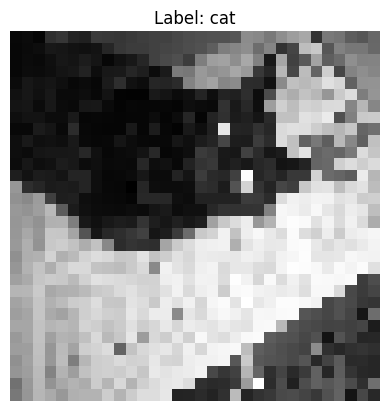

In [4]:
if len(X) > 0:
    idx = 0
    img = X[idx].reshape(32,32)
    label = [k for k,v in mapLabels.items() if v==y[idx]][0]
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

Shuffle and Split Data

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Visualize Sample Images

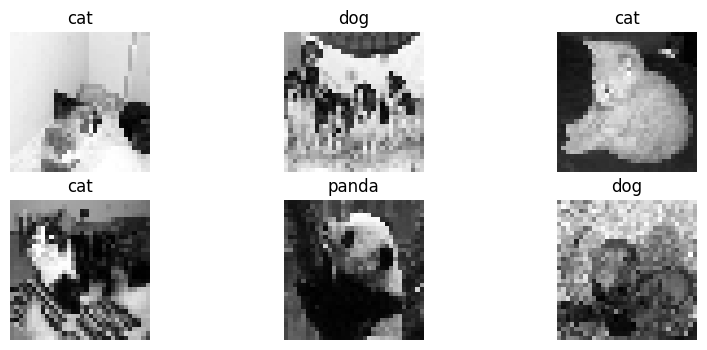

In [6]:
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train_full[i].reshape(32,32), cmap='gray')
    lbl = [k for k,v in mapLabels.items() if v==y_train_full[i]][0]
    plt.title(lbl)
    plt.axis('off')
plt.show()

 k-NN Function

In [7]:
def knn_predict(train_X, train_y, test_X, K=3, distance_metric='L2'):
    preds = []
    for t in test_X:
        if distance_metric=='L1': distances = np.sum(np.abs(train_X - t), axis=1)
        else: distances = np.sqrt(np.sum((train_X - t)**2, axis=1))
        k_labels = train_y[np.argsort(distances)[:K]]
        preds.append(Counter(k_labels).most_common(1)[0][0])
    return np.array(preds)


5-Fold Cross Validation

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
K_values = [1,3,5,7,9]
accuracy_L1, accuracy_L2 = [], []

for K in K_values:
    acc_L1, acc_L2 = [], []
    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
        acc_L1.append(np.mean(knn_predict(X_train, y_train, X_val, K,'L1')==y_val))
        acc_L2.append(np.mean(knn_predict(X_train, y_train, X_val, K,'L2')==y_val))
    accuracy_L1.append(np.mean(acc_L1))
    accuracy_L2.append(np.mean(acc_L2))


Accuracy Table and Best K

In [9]:
print("K\tL1 Accuracy\tL2 Accuracy")
for i,K in enumerate(K_values):
    print(f"{K}\t{accuracy_L1[i]:.3f}\t\t{accuracy_L2[i]:.3f}")

best_K_L1 = K_values[np.argmax(accuracy_L1)]
best_K_L2 = K_values[np.argmax(accuracy_L2)]
print(f"Best K for L1: {best_K_L1}, Best K for L2: {best_K_L2}")


K	L1 Accuracy	L2 Accuracy
1	0.389		0.363
3	0.370		0.344
5	0.381		0.359
7	0.396		0.381
9	0.419		0.385
Best K for L1: 9, Best K for L2: 9


Plot Accuracy Graphs

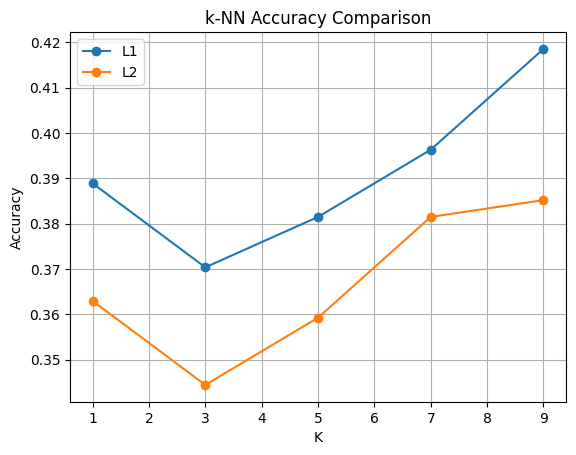

In [10]:
plt.figure(); plt.plot(K_values, accuracy_L1, 'o-', label='L1'); plt.plot(K_values, accuracy_L2, 'o-', label='L2')
plt.title("k-NN Accuracy Comparison"); plt.xlabel("K"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.show()


Top 5 Predictions on Test Set

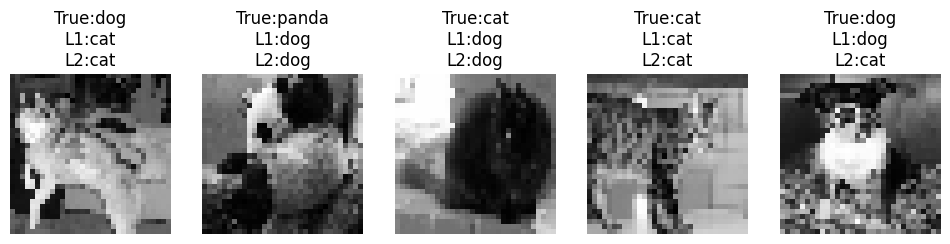

In [11]:
num_test = min(5, len(X_test))
test_indices = np.random.choice(len(X_test), num_test, replace=False)
plt.figure(figsize=(12,4))
for i, idx in enumerate(test_indices):
    img = X_test[idx].reshape(32,32)
    true_label = [k for k,v in mapLabels.items() if v==y_test[idx]][0]
    pred_L1 = [k for k,v in mapLabels.items() if v==knn_predict(X_train_full, y_train_full, [X_test[idx]], best_K_L1,'L1')[0]][0]
    pred_L2 = [k for k,v in mapLabels.items() if v==knn_predict(X_train_full, y_train_full, [X_test[idx]], best_K_L2,'L2')[0]][0]
    plt.subplot(1,num_test,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True:{true_label}\nL1:{pred_L1}\nL2:{pred_L2}")
    plt.axis('off')
plt.show()

Confusion Matrices

Confusion Matrix L1


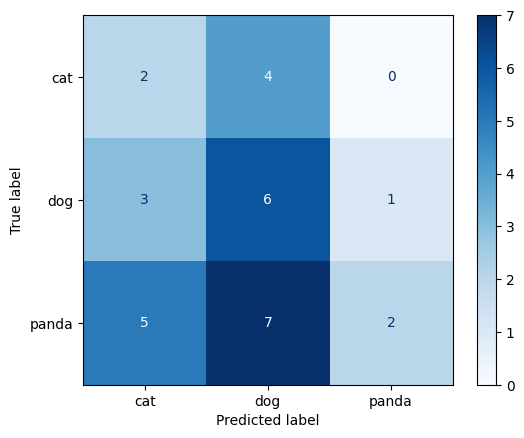

Confusion Matrix L2


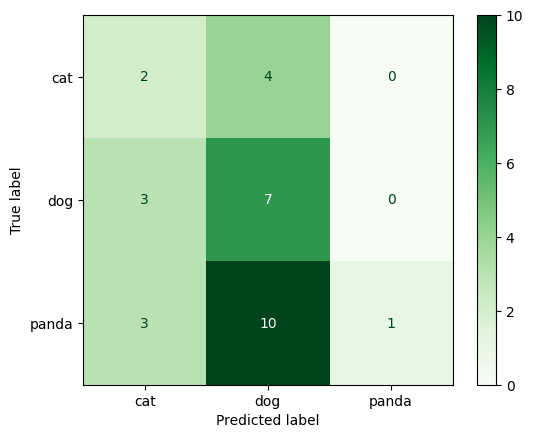

In [12]:
pred_test_L1 = knn_predict(X_train_full, y_train_full, X_test, best_K_L1,'L1')
pred_test_L2 = knn_predict(X_train_full, y_train_full, X_test, best_K_L2,'L2')

cm_L1 = confusion_matrix(y_test, pred_test_L1)
cm_L2 = confusion_matrix(y_test, pred_test_L2)

print("Confusion Matrix L1")
ConfusionMatrixDisplay(cm_L1, display_labels=categories).plot(cmap='Blues')
plt.show()

print("Confusion Matrix L2")
ConfusionMatrixDisplay(cm_L2, display_labels=categories).plot(cmap='Greens')
plt.show()

Discussion

In [13]:
print("Observation:")
print("- L1 and L2 distances perform differently depending on dataset features.")
print("- Best K values help achieve highest accuracy for each metric.")
print("- Confusion matrices show which classes are misclassified more often.")

Observation:
- L1 and L2 distances perform differently depending on dataset features.
- Best K values help achieve highest accuracy for each metric.
- Confusion matrices show which classes are misclassified more often.
